# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    energy,
    sample_sp_exp_mech,
    sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]
NUM_DATA = 100                   # Number of data points. [200]
DIM = 2                          # Dimension of data. [2]

NUM_SUPP = 20                    # Number of support points. [10]
ALPHA = 50                       # Differential privacy level. [50]
ENERGY_POWER = 2.                # Power for energy distance kernel. [2]

___

# 2. Load and Plot Data

In [3]:
# Load data.
#np.random.seed(345)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)

Loaded M=100, DIM=2, SIG=0.03, C=10


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0027


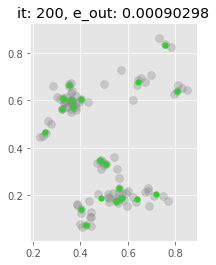

  [*] Time elapsed: 0.86


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF)

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=100, DIM=2, SIG=0.02, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.75
Loaded M=100, DIM=2, SIG=0.02, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.75
Loaded M=100, DIM=2, SIG=0.02, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.72
Loaded M=100, DIM=2, SIG=0.04, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.71
Loaded M=100, DIM=2, SIG=0.04, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.85
Loaded M=100, DIM=2, SIG=0.04, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.78


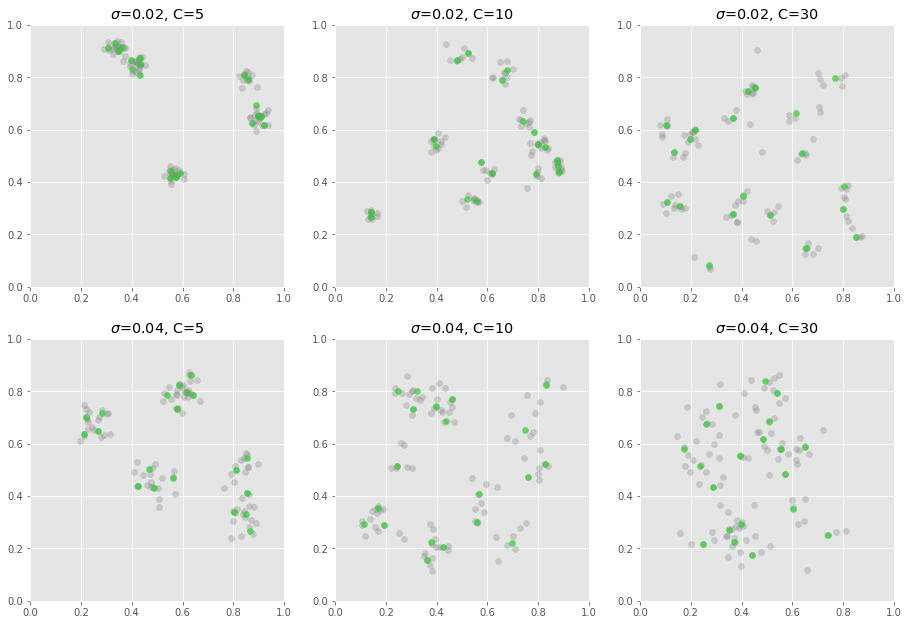

In [5]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(NUM_DATA, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, NUM_SUPP, MAX_ITER,
                                                    LR, is_tf=IS_TF, plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=0.7)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/fig_sp_optimization.png')

___

## 4. Sample support points.

## 4.0 Sample support points with SP + Exponential Mechanism.

In [6]:
PLOT = 1

Exp(2 * U / alpha) = Exp(2 * 0.2758 / 20000.00) = Exp(0.00002758)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.2758 / 20000.000) = Exp(0.0000)

Running chain. Length=22000, Burn=1000, Thin=1000, Step=0.015
Difference factor: 36261.89


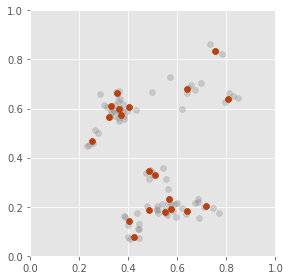

Acceptance rate: 0.000
Energy diff: -0.00012271


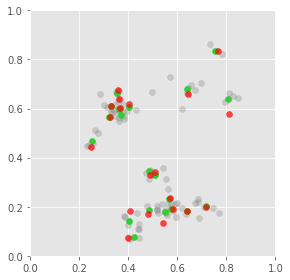

Acceptance rate: 0.212
Energy diff: -0.00001751


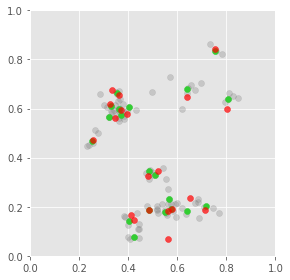

Acceptance rate: 0.229
Energy diff: -0.00016228


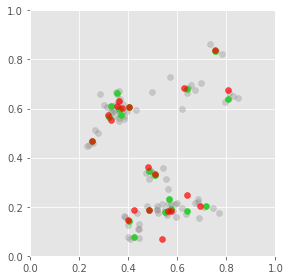

Acceptance rate: 0.240
Energy diff: -0.00006366


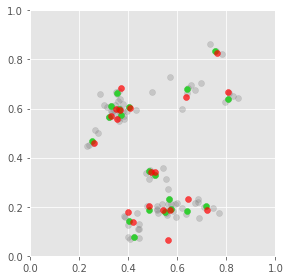

Acceptance rate: 0.240
Energy diff: -0.00007255


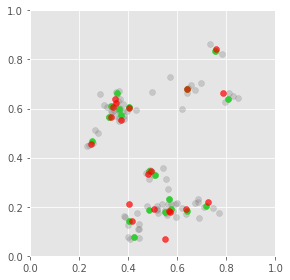

Acceptance rate: 0.241
Energy diff: -0.00013310


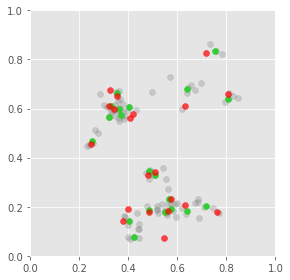

Acceptance rate: 0.246
Energy diff: -0.00020522


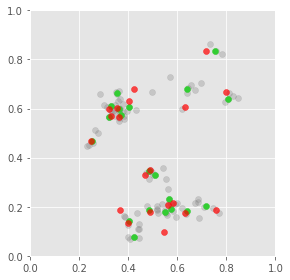

Acceptance rate: 0.249
Energy diff: -0.00002146


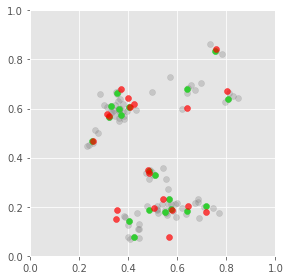

Acceptance rate: 0.250
Energy diff: -0.00004743


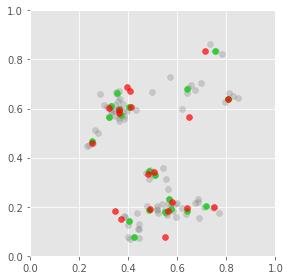

Acceptance rate: 0.252
Energy diff: 0.00003963


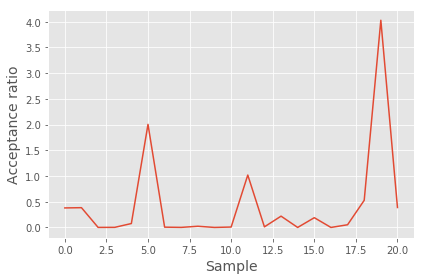

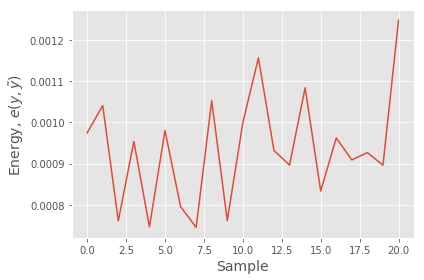

Acceptance rate: 0.251
percent steps that improved energy score: 0.125


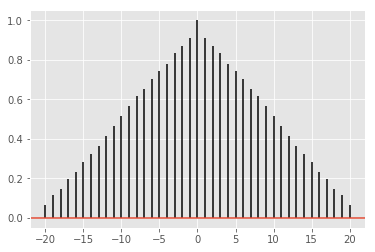

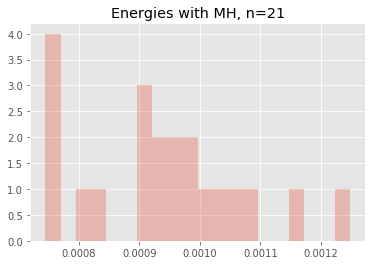

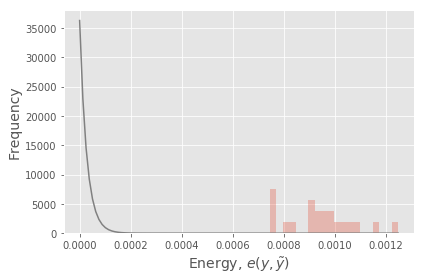

Exponential param: 0.00002758


In [7]:
# Sampling parameters.
NUM_Y_TILDES = 21
ALPHA = 20000  # 10000
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt, 'mh', NUM_Y_TILDES,
                         ALPHA, plot=PLOT)

if PLOT:
    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


    # Compare to Exponential density.
    p = exponential_param = 2. * energy_sensitivity / ALPHA
    xs = np.linspace(0, np.max(energies), 100)
    xs_dens = 1 / p * np.exp(-xs / p)
    plt.plot(xs, xs_dens, c='gray', label='Exponential density')
    plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.savefig('../output/fig_mh_energies.png')
    plt.show()
    print('Exponential param: {:.8f}'.format(p))

## Sample w/ ExpMech on Data Directly (NUM_DATA=NUM_SUPP)

Exp(2 * U / alpha) = Exp(2 * 0.0563 / 50000.00) = Exp(0.00000225)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0563 / 50000.000) = Exp(0.0000)

Running chain. Length=22000, Burn=1000, Thin=1000, Step=0.01
Difference factor: 444162.55


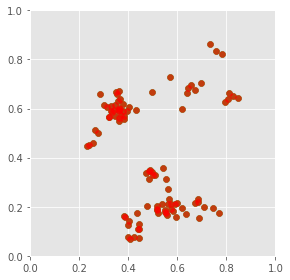

Acceptance rate: 0.000
Energy diff: -0.00000416


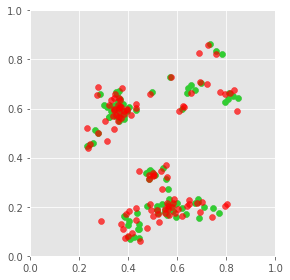

Acceptance rate: 0.539
Energy diff: -0.00000005


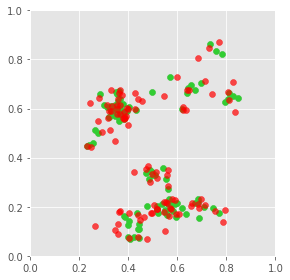

Acceptance rate: 0.531
Energy diff: -0.00000239


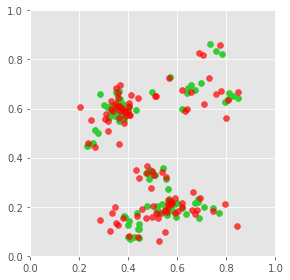

Acceptance rate: 0.526
Energy diff: -0.00000062


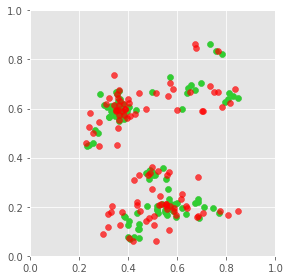

Acceptance rate: 0.528
Energy diff: -0.00000624


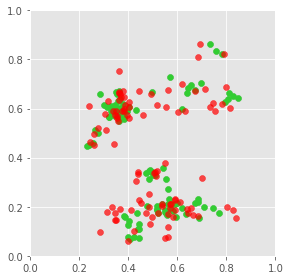

Acceptance rate: 0.523
Energy diff: -0.00000064


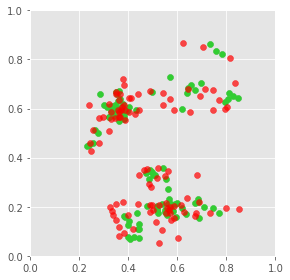

Acceptance rate: 0.526
Energy diff: -0.00000594


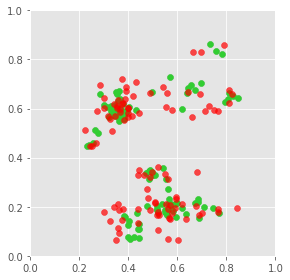

Acceptance rate: 0.526
Energy diff: -0.00001124


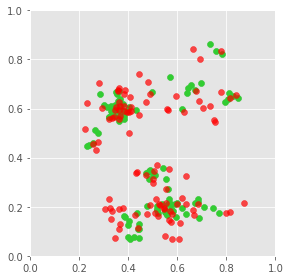

Acceptance rate: 0.526
Energy diff: -0.00000119


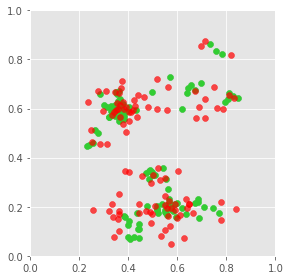

Acceptance rate: 0.525
Energy diff: -0.00000325


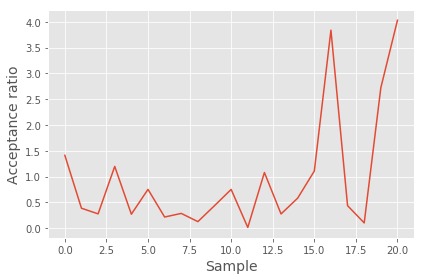

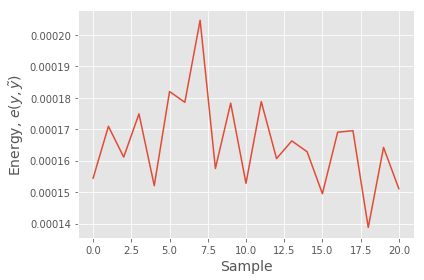

Acceptance rate: 0.525
percent steps that improved energy score: 0.259


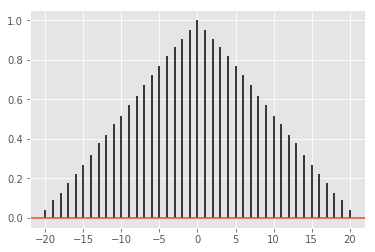

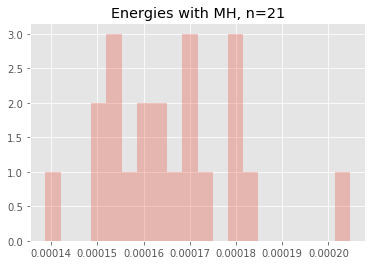

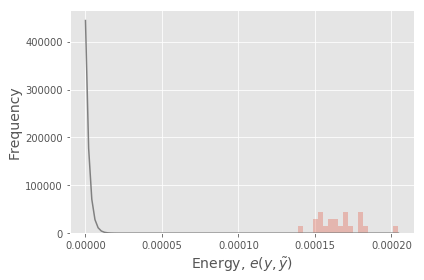

p: 2.2514279912979673e-06


In [19]:
# Sampling parameters.
NUM_Y_TILDES = 21
ALPHA = 50000  # 10000
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x))  # Note: Num supp = len(x).
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.
                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT)

if PLOT:
    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


    # Compare to Exponential density.
    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA
    xs = np.linspace(0, np.max(energies), 100)
    xs_dens = 1 / p * np.exp(-xs / p)
    plt.plot(xs, xs_dens, c='gray', label='Exponential density')
    plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.savefig('../output/fig_mh_energies.png')
    plt.show()
    print('p: {}'.format(p))

In [ ]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

#### Paper: Figure of private support point samples with various alphas.

In [ ]:
example_alphas = [1, 1000, 5000, 10000, 20000]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
for i, alpha in enumerate(example_alphas):
    #np.random.seed(234)
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                         x, y_opt, 'mh',
                                         num_y_tildes=1,
                                         alpha=alpha,
                                         diffusion_mean=True,
                                         plot=False)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(y_tildes[0, :, 0],
                   y_tildes[0, :, 1],
                   c='red', alpha=0.7)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_sp_different_alphas.png')
plt.show()

## ?????? (CUT?) 4.1 Sample support points via MMD w/ DP median of pairwise distances

#### Paper: Figure of private support point samples with various alphas.

In [ ]:
if 0:
    _MAX_ITER = 2001
    _LR = 5e-4

    # Compute median of pairwise distances, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    print('True median: {:.4f}'.format(median_pairwise_dists))

    # "True" support points using MMD.
    y_opt_mmd, mmd_opt = get_support_points(x, NUM_SUPP, _MAX_ITER, _LR,
                                            is_tf=IS_TF,
                                            plot=True,
                                            do_mmd=True,
                                            mmd_sigma=median_pairwise_dists)

In [ ]:
if 0:
    # Get private support points by using MMD with private bandwidth.
    example_alphas = [1, 10, 100, 1000]
    n_alp = len(example_alphas)
    fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
    for i, alpha in enumerate(example_alphas):
        # For this figure, use mean value of noise, instead of actual sample.
        (temp_y_opt_mmd,
         temp_mmd_opt) = sample_sp_mmd_dp_bw(x, ENERGY_POWER, DIM, alpha, NUM_SUPP,
                                             plot=False, use_mean=True)



        axs[i].set_title(r'$\alpha$={}, e={:.8f}'.format(alpha,
                                                         temp_mmd_opt))
        axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
        axs[i].scatter(y_opt_mmd[:, 0], y_opt_mmd[:, 1], c='limegreen', alpha=0.7)
        axs[i].scatter(temp_y_opt_mmd[:, 0], temp_y_opt_mmd[:, 1], c='red', alpha=0.7)
        axs[i].set_xlim((0, 1))
        axs[i].set_ylim((0, 1))

    plt.subplots_adjust(wspace=0.2, hspace=0.2,
                        bottom=0.1, top=0.9, left=0.1, right=0.9)
    plt.savefig('../output/fig_sp_mmd_dp_bw.png')
    plt.show()

___

## 5. Expand to full data set.

## 5.0 KDE with pre-selected bandwidth.

#### Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.

In [ ]:
ALPHA = 100

energy_sensitivity = get_energy_sensitivity(x, num_supp)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))


FULL_SAMPLE_SIZE = NUM_DATA
PLOT = 1

In [ ]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    #np.random.seed(234)
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt,
                                                          ALPHA, bw,
                                                          FULL_SAMPLE_SIZE, 
                                                          method='mh',
                                                          diffusion_mean=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_fixed_bandwidth.png')

## 5.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [ ]:
ALPHA = 1000
STEP_SIZE = 1e-2

PLOT = 1

In [ ]:
#np.random.seed(123)
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'mh', num_y_tildes=1, alpha=ALPHA,
                               diffusion_mean=True)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=NUM_DATA)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_HIGH = 0.05
BW_LOW = 0.0001
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    #lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]

In [ ]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/fig_kde_mle_bw.png')
plt.show()

#### Show samples with best and worst bandwidth.

In [ ]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ')
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ')
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                             bw_best,
                                                             bw_best_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.

In [ ]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))


    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_dp_mle.png')

## (CUT?) 5.2 KDE with DP median of pairwise distances as bandwidth.

Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W. <- WITH WHAT BANDWIDTH?

In [ ]:
# Show data and y_tilde.
ALPHA=1000
STEP_SIZE = 2e-3
SAMPLE_SIZE = NUM_DATA


# Compute median of pairwise distanes, and use that as bandwidth.
median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
private_median = (median_pairwise_dists +
                  np.random.laplace(
                      scale=sensitivity_median_pairwise_dists / ALPHA))
print(median_pairwise_dists)
print(private_median)
BANDWIDTH = private_median

# Sample support points using private median.
# First  : Derive support points using MMD with private median.
# Second : Expand using kernel density estimator.
#np.random.seed(234)
(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                      energy_sensitivity,
                                                      x, y_opt, STEP_SIZE,
                                                      ALPHA, BANDWIDTH,
                                                      SAMPLE_SIZE,
                                                      method='mh')

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
            alpha=0.3, label='FULL')

plt.title('MH, PRE-SELECTED w = {}'.format(BANDWIDTH))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## 5.3 Repeated draws of private support points.

In [ ]:
ALPHA = 50
STEP_SIZE = 5e-3

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, STEP_SIZE,
                                                          ALPHA, BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh')
    new_sample.append(y_tilde)


new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')
#plt.title('Diffusion, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
#    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
#    BANDWIDTH))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/fig_repeated_samples.png')
plt.show()

# End.